In [1]:
import gensim.downloader as api
from nltk import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn

In [2]:
class Embedder:
    
    """
        A simple embedder that takes generates word embeddings:
        
        Parameters
        ----------
        model_name: str
            The name of the gensim model to use for the generation of word embeddings
        
    """
    
    def __init__(self, model_name: str = "word2vec-google-news-300"):
        
        try:
            
            self.model = api.load(model_name)
        
        except Exception as e:
            
            print(f"Experienced the following error: {e}")
        
    def embed(self, word: str) -> np.array:
        
        """
            An embedding function
            
            Parameters
            ----------
            word: str
                the word to embed
            
            Returns
            -------
            word_embeddings: np.darray
                the numpy array of the word embedding
                
        """
        
        word = word.lower()
        return self.model[word]
        

In [3]:
class WordTokenizer:
    """
        A simple sentence tokenizer that makes use of the nltk library
    """
    
    def __init__(self):
        
        self.tokenizer = word_tokenize
        
    def tokenize(self, sentence: str) -> list[str]:
        """
            A tokenize function that takes as input a sentence and generates an array of tokenized words
            
            Parameters
            ----------
            sentence: str
                the sentence to tokenize
            
            
            Returns
            -------
            tokenized_sentence: a list of strings
        """
        
        try:
            sentence = re.sub(r"[^a-zA-Z]", " ", sentence.lower()) 
            return self.tokenizer(sentence)
        except Exception as e:
            print(f"Experienced the following error: {e}")

In [4]:
tokenizer = WordTokenizer()

In [5]:
embedder = Embedder()

In [6]:
class SimpleSelfAttention:
    """
        This class calculates self attention. Weights not trainable. 
    """
    
    def __init__(self, embedder = Embedder, tokenizer = WordTokenizer):
        
        self.embedder = Embedder()
        self.tokenizer = WordTokenizer()
        
    
    def forward(self, sentence):
        words = self.tokenizer.tokenize(sentence)
        embedding_list = []
        for word in words:
            embedding_list.append(self.embedder.embed(word))
        sentence_embeddings = torch.Tensor(embedding_list)
        attention_scores = sentence_embeddings @ sentence_embeddings.T
        attention_weights = torch.softmax(attention_scores, dim=-1)
        return attention_weights.numpy()
        
    def visualize(self, sentence):
        words = self.tokenizer.tokenize(sentence)
        attention_weights = self.forward(sentence)
        plt.imshow(attention_weights)
        plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        plt.xticks(np.arange(len(words)), words)
        plt.yticks(np.arange(len(words)), words)
        for i in range(attention_weights.shape[0]):
            for j in range(attention_weights.shape[0]):
                plt.text(i-.25, j+.125, f"{attention_weights[i][j]:.2f}", color="red")
        plt.show()

In [7]:
attentionClass = SimpleSelfAttention()

In [8]:
sentence = "The old dog walks while the young puppy runs."

In [9]:
attentionClass.forward(sentence)

/tmp/ipykernel_26966/197665489.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  sentence_embeddings = torch.Tensor(embedding_list)


array([[2.0269302e-01, 7.9344966e-02, 7.6948598e-02, 9.1626562e-02,
        9.7607203e-02, 2.0269302e-01, 9.7342849e-02, 5.8999803e-02,
        9.2743956e-02],
       [7.7352589e-03, 8.4597331e-01, 1.8012438e-02, 1.5491987e-02,
        9.9599054e-03, 7.7352589e-03, 4.5087162e-02, 4.1279215e-02,
        8.7254439e-03],
       [1.1981113e-04, 2.8768234e-04, 7.2356004e-01, 7.8221876e-04,
        1.4695898e-04, 1.1981113e-04, 1.8407981e-04, 2.7457556e-01,
        2.2376943e-04],
       [4.6553392e-05, 8.0738624e-05, 2.5524767e-04, 9.9665630e-01,
        5.4177748e-05, 4.6553392e-05, 1.4917528e-04, 2.5185972e-04,
        2.4593535e-03],
       [6.5029971e-02, 6.8066195e-02, 6.2882788e-02, 7.1043253e-02,
        4.8195955e-01, 6.5029971e-02, 6.3738756e-02, 6.0284086e-02,
        6.1965499e-02],
       [2.0269302e-01, 7.9344966e-02, 7.6948598e-02, 9.1626562e-02,
        9.7607203e-02, 2.0269302e-01, 9.7342849e-02, 5.8999803e-02,
        9.2743956e-02],
       [1.2773850e-02, 6.0689718e-02, 1.

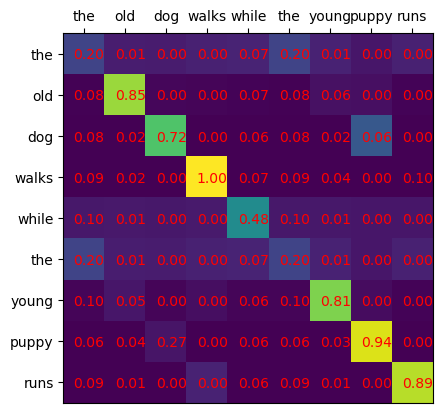

In [10]:
attentionClass.visualize(sentence)

<h1 align="center"> The Attention Mechanism </h1>

![title](attention.png)

In [11]:
class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.query = nn.Parameter(torch.rand(d_in, d_out))
        self.key = nn.Parameter(torch.rand(d_in, d_out))
        self.value = nn.Parameter(torch.rand(d_in, d_out))
        self.attention_weights = None
        
        
    def forward(self, x: np.array, causal=False):
        queries = x @ self.query
        keys = x @ self.key
        values = x @ self.value
        
        
        attention_scores = queries @ keys.T
        
        if causal:
            mask = torch.tril(torch.ones(x.shape[0], x.shape[0]))
            attention_scores = attention_scores * mask
            row_sums = torch.sum(attention_scores, dim=-1)
            attention_weights = attention_scores/row_sums
        else:
        
            attention_weights = torch.softmax(
                attention_scores/(keys.shape[1] ** 0.5), 
            dim=-1)
        self.attention_weights = attention_weights
        context_vec = attention_weights @ values
        
        return context_vec

In [12]:
sentence = "The old dog walks slowly while the young puppy runs fast."

In [13]:
words = tokenizer.tokenize(sentence)

In [14]:
def generate_word_embedding(words):
    embedding_list = []
    for word in words:
        embedding_list.append(embedder.embed(word))
    word_embeddings = torch.Tensor(embedding_list)
    return word_embeddings

In [15]:
self_attention_v1 = SelfAttention_v1(300, 128)

In [16]:
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, dropout=0.5):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        
        self.query = nn.Linear(d_in, d_out)
        self.key = nn.Linear(d_in, d_out)
        self.value = nn.Linear(d_in, d_out)
        self.attention_scores = None
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, causal=False):
        
        # x -> words x d_in
        
        query = self.query(x) # words x d_out
        key = self.key(x) # words x d_out
        value = self.value(x) # words x d_out
        
        attention_scores = query @ key.T # words x words
        
        if causal:
            mask = torch.triu(torch.ones(x.shape[0], x.shape[0]),  diagonal=1)
            attention_scores = attention_scores.masked_fill(mask.bool(), -torch.inf)
            
        attention_weights = torch.softmax(
            attention_scores / (key.shape[1] ** 0.5),
            dim = -1
        ) # words x words
        
        
        self.attention_weights = attention_weights
        
        masked_attention_weights = self.dropout(attention_weights)
        
        context_vec = masked_attention_weights @ value
        
        
        return context_vec
        

In [17]:
self_attention_v2 = SelfAttention_v2(300, 128, dropout=0.1)

In [18]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, dropout=0.2, qkv_bias=False, context_size=10):
        super().__init__()
        self.wQ = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.wK = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.wV = nn.Linear(d_in, d_out, bias=qkv_bias)
        
        self.dropout = nn.Dropout(dropout)
        
        self.register_buffer(
                "mask",
                torch.triu(torch.ones(context_size, context_size), diagonal=1)
        )
        
    
    def forward(self, x):
        q = self.wQ(x)
        k = self.wK(x)
        v = self.wV(x)
        
        attention_scores = q @ k.transpose(1, 2)
        
        attention_scores = attention_scores.masked_fill(self.mask.bool(), -torch.inf)
        
        
        attention_weights = torch.softmax(attention_scores / (k.shape[-1]**0.5), 
                                          dim=-1)
        
        context_vector = attention_weights @ v
        
        return context_vector

In [19]:
s1 = "The aurora danced vividly, painting the frozen sky with brilliance."
s2 = "Time travelers whispered secrets, unraveling mysteries from forgotten ancient civilizations."

In [20]:
words_1 = tokenizer.tokenize(s1)
words_2 = tokenizer.tokenize(s2)

In [21]:
embeddings_1 = generate_word_embedding(words_1)
embeddings_2 = generate_word_embedding(words_2)

In [22]:
x = torch.stack([embeddings_1, embeddings_2], dim=0)

In [29]:
x.shape

torch.Size([2, 10, 300])

In [23]:
causal_attention = CausalAttention(300, 128)

In [24]:
class MultiHeadedSeqAttention(nn.Module):
    def __init__(self, d_in, d_out, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.heads = nn.ModuleList(
            [CausalAttention(
                d_in, d_out)
            for i in range(num_heads)]
        )
        
    def forward(self, x):
        
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [25]:
multi_attention = MultiHeadedSeqAttention(300, 128, 4)

In [26]:
out = multi_attention(x)

In [32]:
out.shape

torch.Size([2, 10, 512])

In [33]:
512/4

128.0

In [35]:
out.view(2, 10, 4, 128).shape

torch.Size([2, 10, 4, 128])

In [80]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, d_in, d_out, num_heads, dropout=0.2):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.num_heads = num_heads
        
        assert d_out % num_heads == 0, "Number of heads must divide the embedding dimension"
        
        self.dropout = nn.Dropout(dropout)
        
        self.w_keys = nn.Linear(d_in, d_out)
        self.w_values = nn.Linear(d_in, d_out)
        self.w_queries = nn.Linear(d_in, d_out)
        
        
    def forward(self, x):
        
        b, w, _ = x.shape
        dv = self.d_out // self.num_heads
        
        # x -> (b, w, d_in)
        
        # qkv -> (b, w, d_out)
        
        keys = self.w_keys(x).view(b, w, self.num_heads, dv)
        queries = self.w_queries(x).view(b, w, self.num_heads, dv)
        values = self.w_values(x).view(b, w, self.num_heads, dv)
        
        # qkv -> (b, w, num_heads, dv)
        
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        
        # qkv -> (b, num_heads, w, dv)
        
        attention_mask = queries @ keys.transpose(2, 3)
        
        # attention_mask -> (b, num_heads, w, w)
        
        attention_weights = torch.softmax(attention_mask / (dv ** 0.5), dim=-1)
        
        # attention_weights -> (b, num_heads, w)
        
        context_vector = attention_weights @ values
        
        # context_vector -> (b, num_heads, d_out)
        
        return context_vector.transpose(1, 2).contiguous().view(b, w, self.d_out)

In [81]:
mha = MultiHeadedAttention(300, 128, 4)

In [82]:
mha(x).shape

torch.Size([2, 10, 128])